## Esquema General
<img src="../figures/luker_recipes.png" alt="luker recipes" width="800">

## Análisis Exploratorio Datos Recetas

### Librerías

In [43]:
import re
from collections import defaultdict
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from pandas.errors import PerformanceWarning

warnings.filterwarnings("ignore", category=PerformanceWarning)
FILE_PATH = r"..\data\formulacion_y_sensorial.xlsx"

### Construcción DataFrame Recetas

In [33]:
df_form = pd.read_excel(FILE_PATH, sheet_name=0)
df_form.columns = ["codigo", "ingrediente", "mezcla"]
df_form.iloc[:,0] = df_form.iloc[:,0].ffill()
df_form = df_form.pivot_table(index="codigo", columns="ingrediente", values="mezcla")
def _clean_colname(c):
    c = str(c).replace("\n", "/")
    c = re.sub(r"\s+", " ", c).strip()
    c = c.replace(" /", "/").replace("/ ", "/")
    return c
df_form = df_form.rename(columns=_clean_colname)
# parsing codes
def _parse_codes(colname: str):
    # Primary rule: exact 7-digit codes
    codes = re.findall(r"\d{7}", colname)
    return list(dict.fromkeys(codes))  # dedupe, keep order
cols_with_codes = {col: _parse_codes(col) for col in df_form.columns}

df_codes_expanded = pd.DataFrame(index=df_form.index)
conflict_rows = {}

for col, codes in cols_with_codes.items():
    src = df_form[col]  # the source series
    for code in codes:
        if code in df_codes_expanded:
            # detect true conflicts (both non-null and different)
            existing = df_codes_expanded[code]
            both_non_null = existing.notna() & src.notna()
            diffs = both_non_null & (existing != src)
            if diffs.any():
                conflict_rows.setdefault(code, []).extend(src.index[diffs].tolist())
            # keep existing non-nulls; fill only missing with new values
            df_codes_expanded[code] = existing.combine_first(src)
        else:
            df_codes_expanded[code] = src

# If the same code appeared in multiple source columns, coalesce row-wise
unique_codes = pd.Index(pd.unique(df_codes_expanded.columns))
coalesced_cols = []
for code in unique_codes:
    sub = df_codes_expanded.loc[:, df_codes_expanded.columns == code]
    # Optional: detect conflicts (rows where two non-null values disagree)
    # Only meaningful if values are not all identical per row
    try:
        conflict_mask = sub.nunique(axis=1, dropna=True) > 1
        if conflict_mask.any():
            # You can inspect these rows if needed:
            print(f"[WARN] Code {code}: {conflict_mask.sum()} rows have conflicting values; taking first non-null.")
            pass
    except Exception:
        # Non-comparable types; just skip conflict check
        pass

    # Coalesce left-to-right: first non-null across duplicates
    merged_series = sub.bfill(axis=1).iloc[:, 0]
    merged_series = sub.iloc[:, 0]
    merged_series.name = code
    coalesced_cols.append(merged_series)
df_codes_expanded = pd.concat(coalesced_cols, axis=1)

class DSU:
    def __init__(self):
        self.p = {}
        self.r = {}
    def _add(self, x):
        if x not in self.p:
            self.p[x] = x
            self.r[x] = 0
    def find(self, x):
        self._add(x)
        if self.p[x] != x:
            self.p[x] = self.find(self.p[x])
        return self.p[x]
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.r[ra] < self.r[rb]:
            self.p[ra] = rb
        elif self.r[ra] > self.r[rb]:
            self.p[rb] = ra
        else:
            self.p[rb] = ra
            self.r[ra] += 1

dsu = DSU()
for _, codes in cols_with_codes.items():
    # union all codes that appeared together in the same header
    for i in range(len(codes) - 1):
        dsu.union(codes[i], codes[i+1])

# Materialize groups
groups = defaultdict(list)
for code in unique_codes:
    groups[dsu.find(code)].append(code)
    
# Sort members in each group (as integers if possible)
def _sort_codes(lst):
    try:
        return sorted(lst, key=lambda x: int(x))
    except Exception:
        return sorted(lst)

equivalence_groups = {root: _sort_codes(members) for root, members in groups.items()}

# Merge columns by equivalence group
merged_cols = []
merged_names = []
for root, members in equivalence_groups.items():
    # only keep members that actually exist in df (defensive)
    if root == "2000614":
        pass
    present = [m for m in members if m in df_codes_expanded.columns]
    if not present:
        continue

    block = df_codes_expanded[present]
    # Coalesce across the group's columns, row-wise
    s = block.bfill(axis=1).iloc[:, 0]
    # Canonical column name = smallest code in the group
    canonical = _sort_codes(present)[0]
    s.name = canonical
    merged_cols.append(s)
    merged_names.append(canonical)

df_equiv_merged = pd.concat(merged_cols, axis=1) if merged_cols else pd.DataFrame(index=df_form.index)

In [38]:
# Sort members in each group (as integers if possible)
def _sort_codes(lst):
    try:
        return sorted(lst, key=lambda x: int(x))
    except Exception:
        return sorted(lst)

equivalence_groups = {root: _sort_codes(members) for root, members in groups.items()}

# Merge columns by equivalence group
merged_cols = []
merged_names = []
for root, members in equivalence_groups.items():
    # only keep members that actually exist in df (defensive)
    if root == "2000614":
        pass
    present = [m for m in members if m in df_codes_expanded.columns]
    if not present:
        continue

    block = df_codes_expanded[present]
    # Coalesce across the group's columns, row-wise
    s = block.bfill(axis=1).iloc[:, 0]
    # Canonical column name = smallest code in the group
    canonical = _sort_codes(present)[0]
    s.name = canonical
    merged_cols.append(s)
    merged_names.append(canonical)

df_equiv_merged = pd.concat(merged_cols, axis=1) if merged_cols else pd.DataFrame(index=df_form.index)
print(df_equiv_merged.shape)
df_equiv_merged.head(10)

(217, 150)


,2000018,2000020,2000021,2000023,2000024,2000025,2000027,2000026,2000036,2000037,...,4101920,4102148,4102402,4102686,4103026,4110022,4200321,4500322,4500358,4500359
codigo,,,,,,,,,,,,,,,,,,,,,
PNM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.00,NaN,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.49,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.00,NaN,22.5,...,24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
{k: v for k, v in equivalence_groups.items() if len(v) > 1}

{'2000021': ['2000021', '2000302'],
 '2000696': ['2000023', '2000696'],
 '2000025': ['2000025', '2000829'],
 '2000614': ['2000026',
  '2000031',
  '2000606',
  '2000614',
  '2000639',
  '2000668',
  '2000684',
  '2000685',
  '2000831',
  '2000833',
  '2000835',
  '2001117'],
 '2000889': ['2000889', '2000970', '2000971'],
 '4100107': ['4100107', '4102615'],
 '4101441': ['4101441', '4102338']}

### Construcción DataFrame Sensorial

In [39]:
df_sens = df_form = pd.read_excel(FILE_PATH, sheet_name=1)
df_sens = df_sens.set_index("CODIGO \nINTERNO").dropna(how='all')
print(df_sens.shape)
df_sens.head(10)

(120, 26)


,AROMA,SABOR A\nCACAO,NIVEL DE \nDULCE,VEL. FUSION,ACIDEZ,AMARGO,FRUTAL,ASTRINGENCIA,COLOR,DUREZA,...,NIVEL DE\n ESENCIA,PULIDO,TEXTURA,GRANULOSIDAD,NUEZ,CROCANCIA,APARIENCIA,FLORAL,MOHO,VERDE
CODIGO INTERNO,,,,,,,,,,,,,,,,,,,,,
PNM1,5.0,4.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM2,5.0,4.5,4.5,3.0,NaN,NaN,NaN,NaN,4.5,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM3,4.5,4.5,NaN,NaN,0.5,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM7,5.0,5.0,2.0,2.0,NaN,NaN,NaN,NaN,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM8,4.5,3.5,4.0,2.0,0.0,3.0,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM11,5.0,4.0,4.0,5.0,0.0,3.5,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM12,5.0,4.0,4.0,NaN,1.0,3.5,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM14,5.0,3.5,3.5,5.0,0.0,4.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM15,NaN,3.5,NaN,NaN,0.5,2.0,1.5,0.5,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0


In [41]:
idx = list(set(df_sens.index) & set(df_equiv_merged.index))
df_sens_final = df_sens.loc[idx, ["ACIDEZ", "AMARGO", "AROMA", "ASTRINGENCIA", "NIVEL DE \nDULCE", "DUREZA", "IMP. GLOBAL", "VEL. FUSION"]]
df_sens_final.columns = ['acidez', 'amargor', 'aroma', 'astringencia', 'dulce', 'dureza',
                         'impresion_global', 'velocidad_fusion']
df_sens_final

,acidez,amargor,aroma,astringencia,dulce,dureza,impresion_global,velocidad_fusion
CODIGO INTERNO,,,,,,,,
PNM192,2.0,6.0,5.0,2.0,2.0,NaN,NaN,5.0
PNM23,NaN,NaN,5.0,NaN,4.5,5.0,NaN,3.0
PNM206,NaN,NaN,4.0,NaN,5.5,3.5,NaN,5.0
PNM35,0.0,3.0,5.0,1.0,5.0,NaN,NaN,5.0
PNM93,1.5,4.0,5.0,1.0,4.0,NaN,NaN,5.5
...,...,...,...,...,...,...,...,...
PNM2,NaN,NaN,5.0,NaN,4.5,4.0,NaN,3.0
PNM64,0.0,4.5,5.0,1.0,2.0,NaN,NaN,5.0
PNM70,NaN,NaN,4.5,NaN,5.5,4.0,NaN,3.5


In [42]:
df_recipe_final = df_equiv_merged.loc[idx].dropna(axis=1, how='all')
df_recipe_final

,2000020,2000021,2000023,2000025,2000027,2000026,2000036,2000037,2000038,2000039,...,4101248,4101253,4101345,4101346,4101347,4101374,4101441,4101764,4101774,4101920
codigo,,,,,,,,,,,,,,,,,,,,,
PNM192,NaN,NaN,NaN,NaN,NaN,68.50,NaN,16.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM206,NaN,NaN,NaN,NaN,NaN,9.00,NaN,23.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.38,NaN,27.5
PNM35,NaN,NaN,NaN,NaN,NaN,29.00,NaN,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM93,NaN,NaN,NaN,NaN,NaN,42.50,NaN,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNM2,NaN,NaN,NaN,NaN,NaN,9.39,NaN,12.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM64,NaN,NaN,NaN,NaN,NaN,44.00,NaN,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNM70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


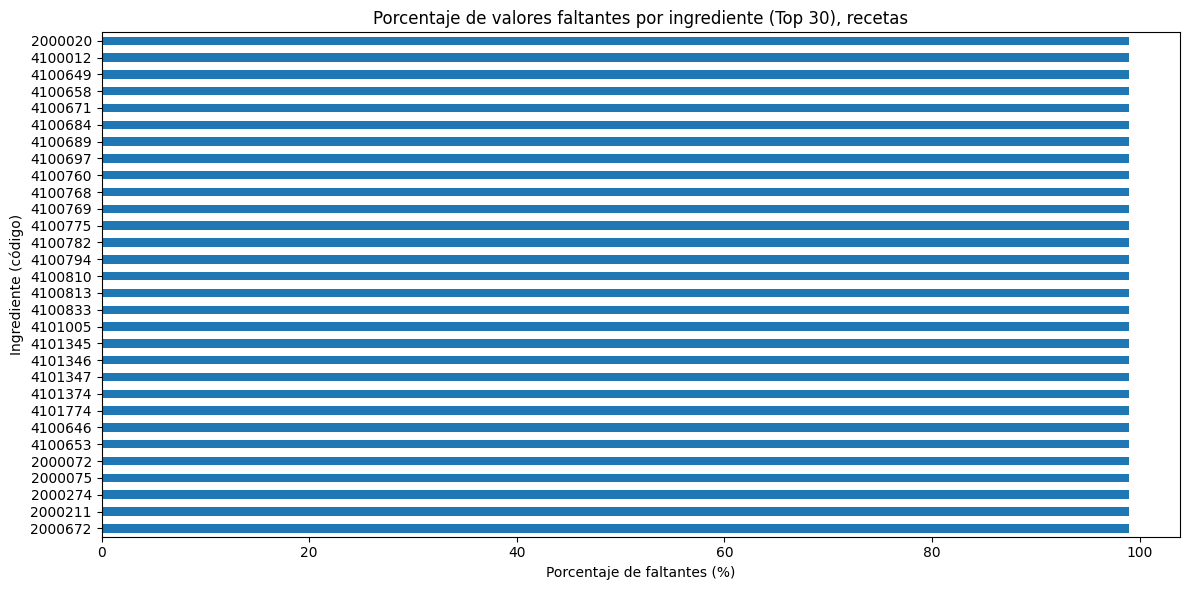

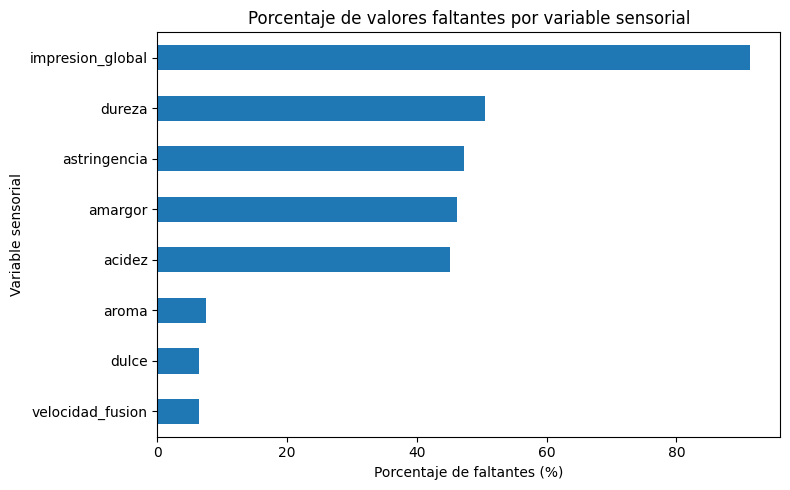

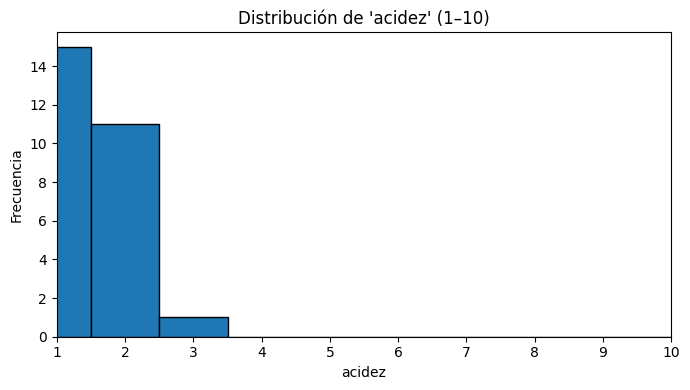

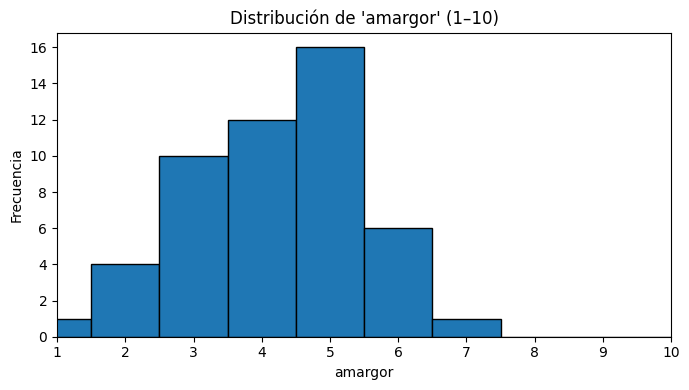

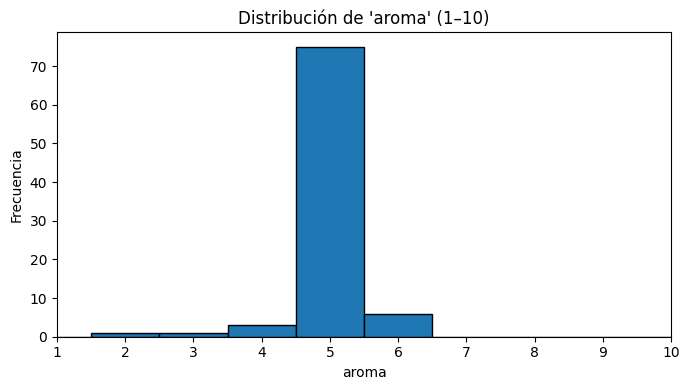

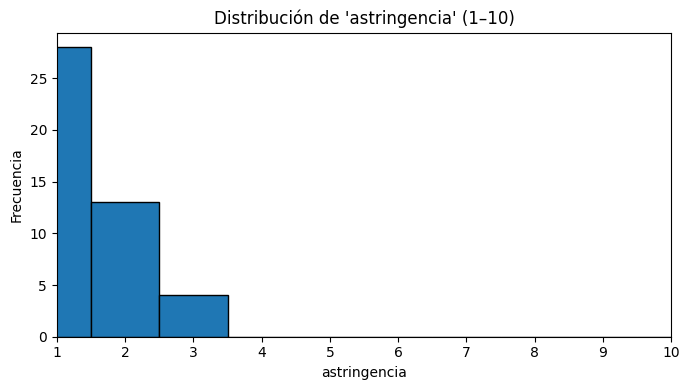

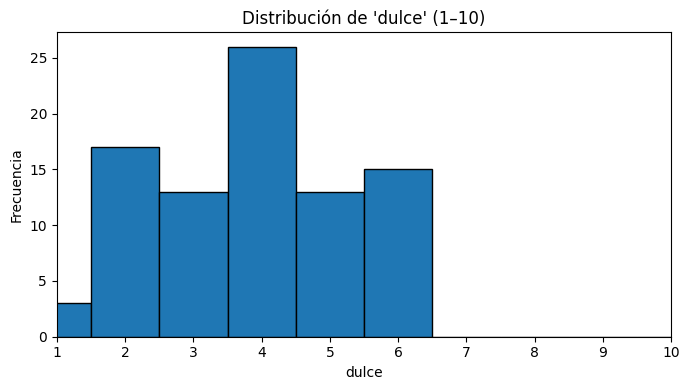

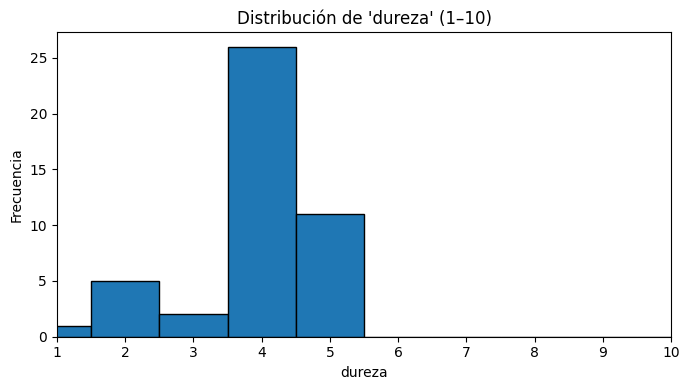

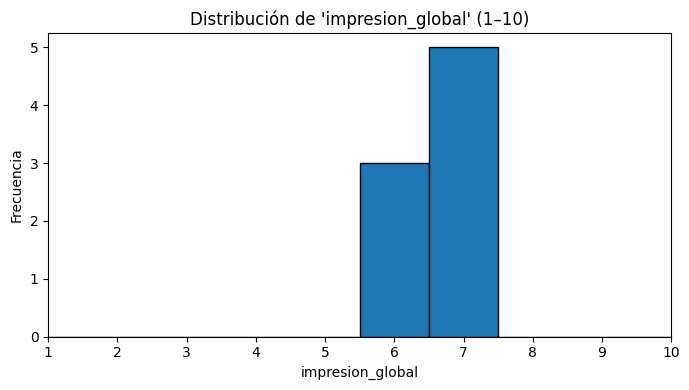

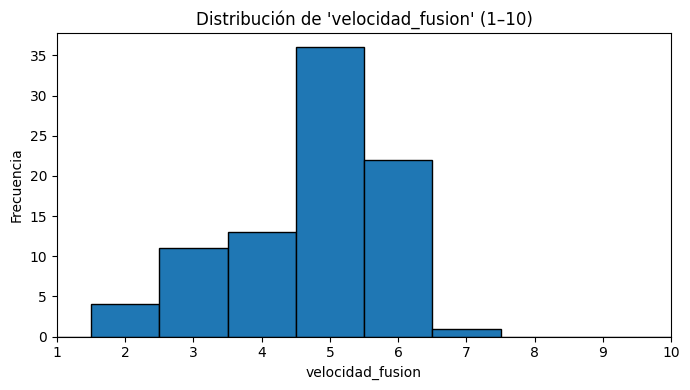

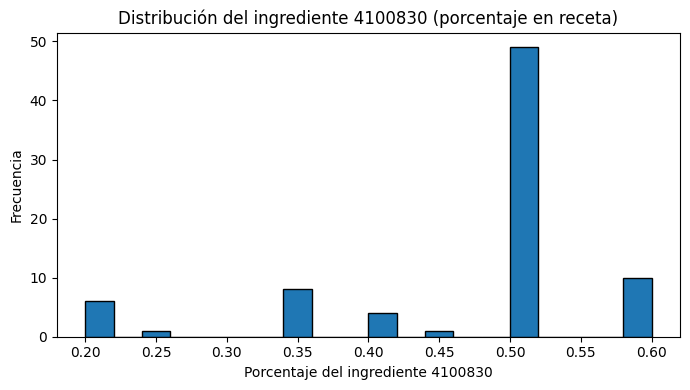

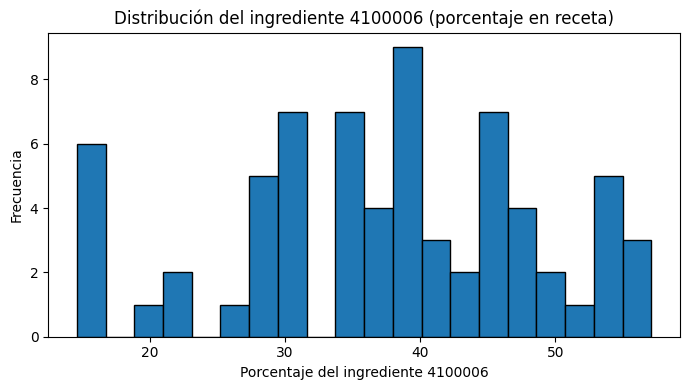

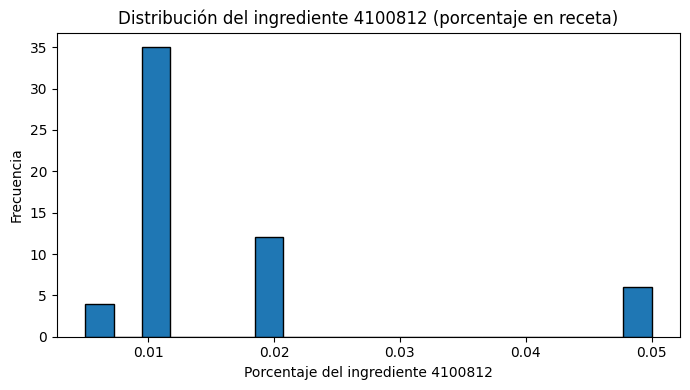

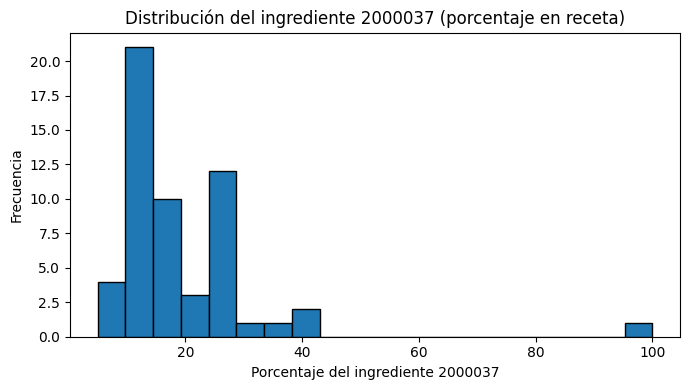

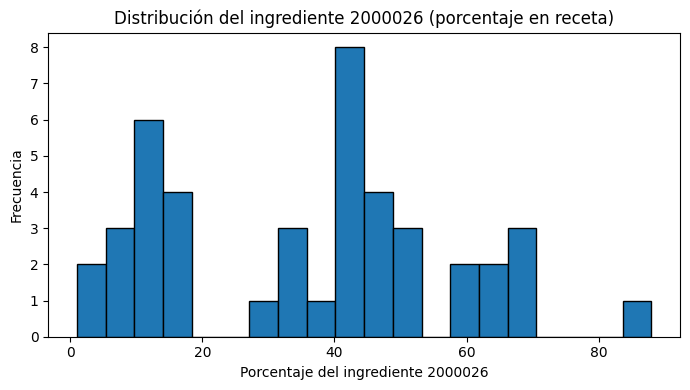

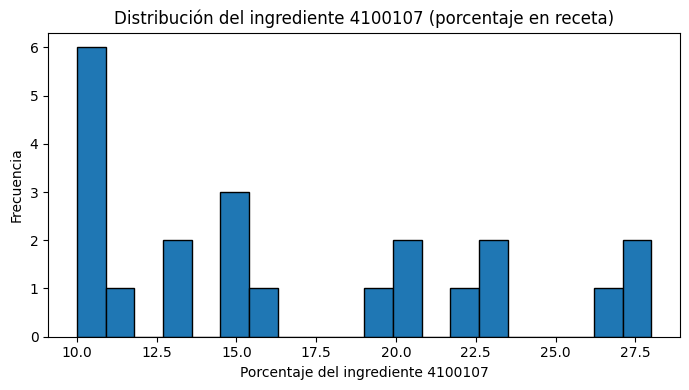

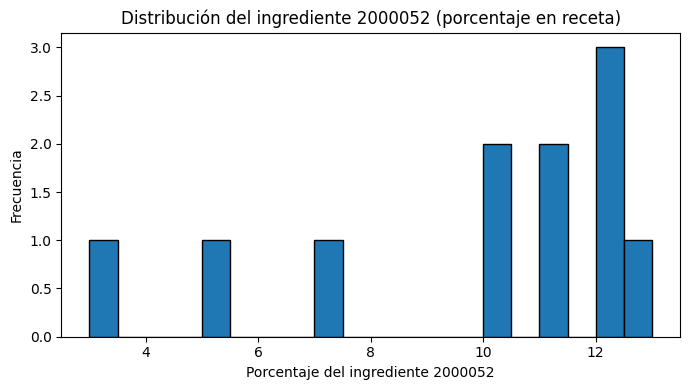

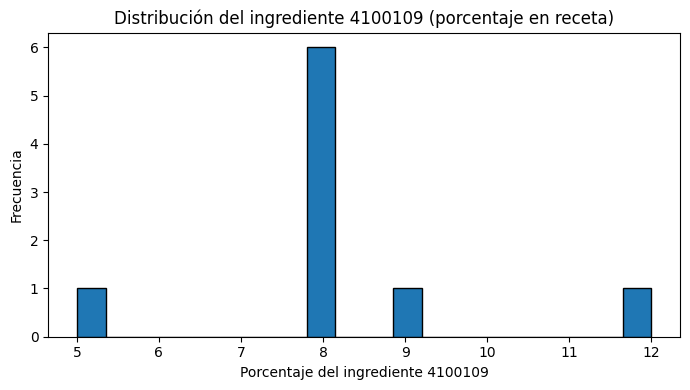

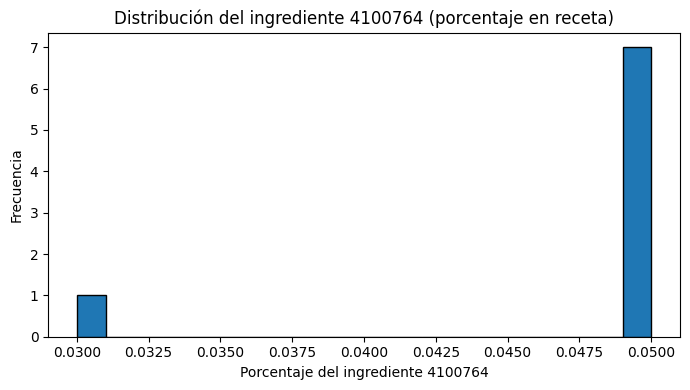

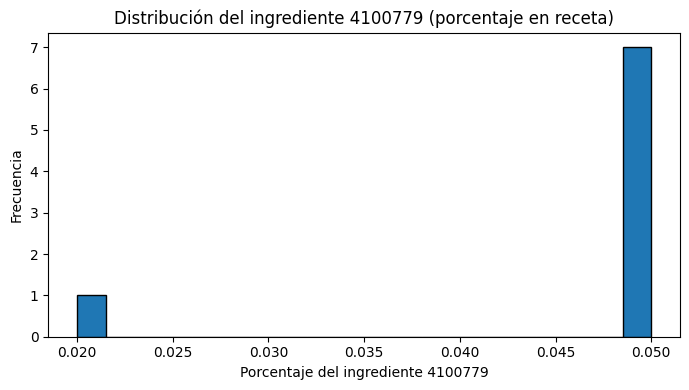

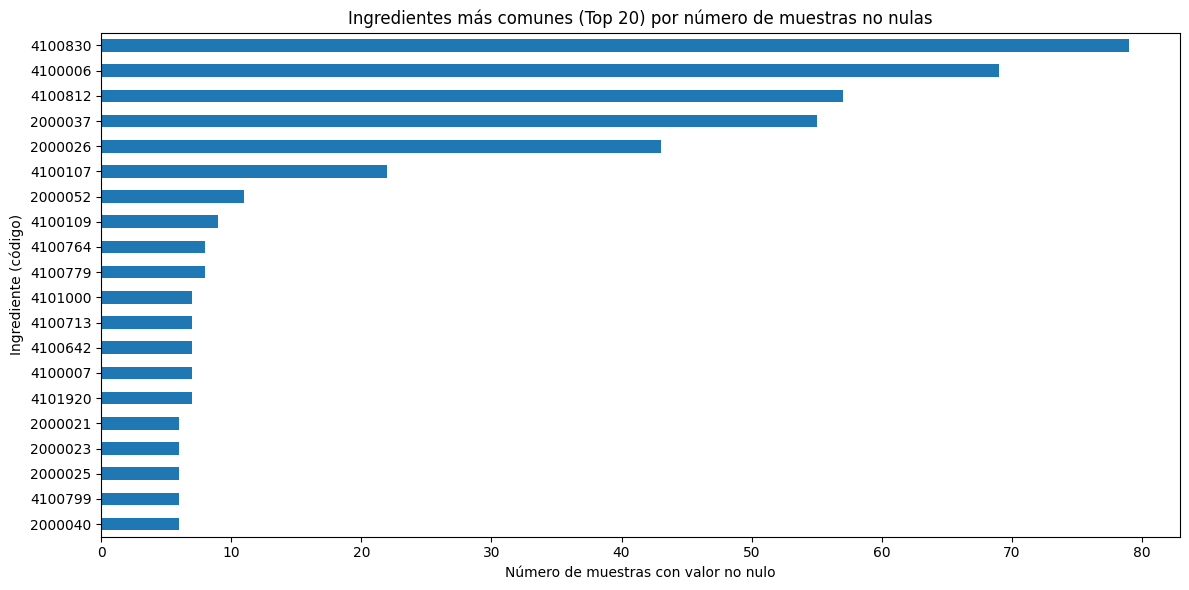

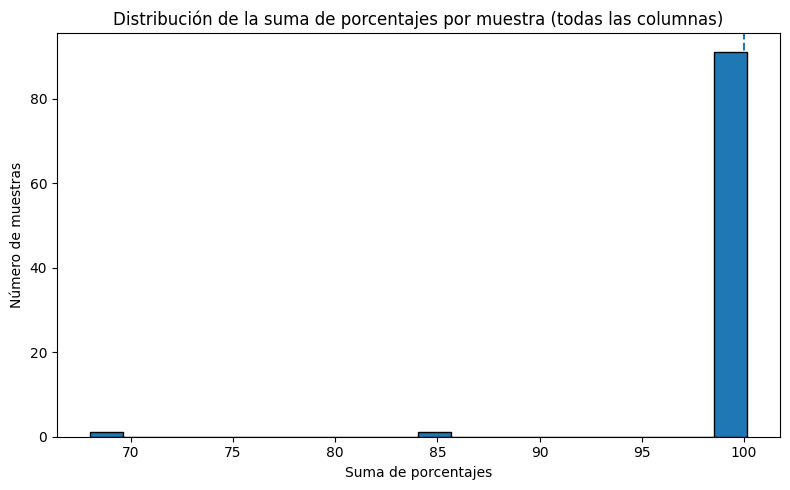

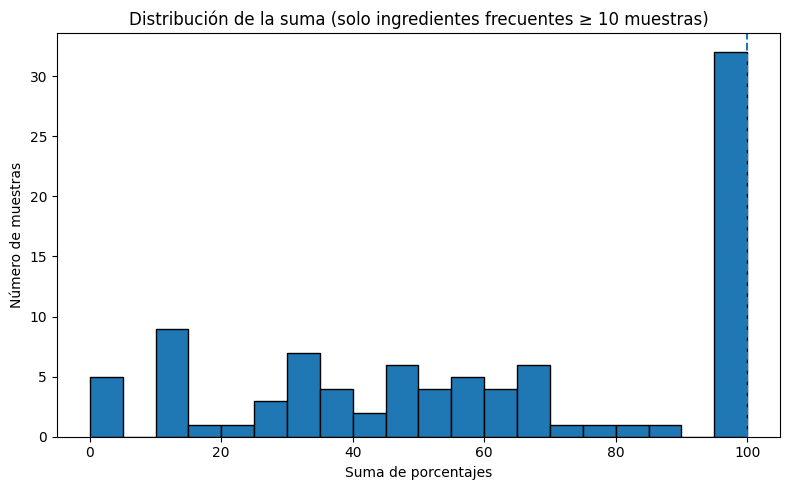

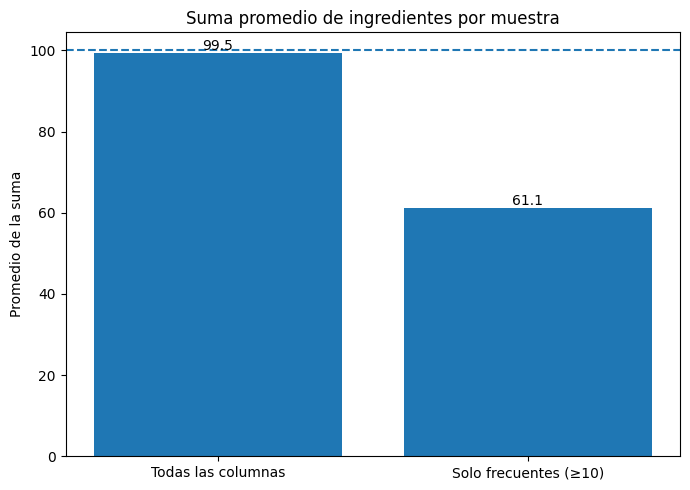

• Media suma (todas): 99.50
• Media suma (frecuentes ≥10): 61.14
• % de muestras con suma entre 98 y 102 (todas): 97.8%


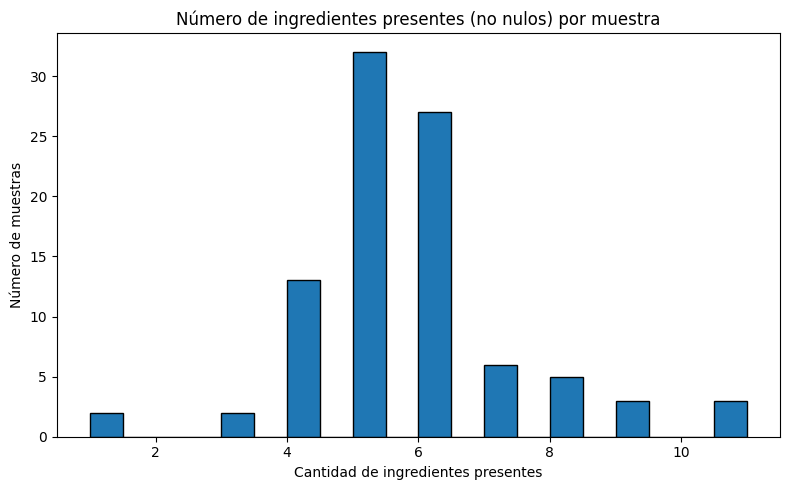

c:\Users\ASUS\Desktop\python-gcpds.luker_multiple_annotators\venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ASUS\Desktop\python-gcpds.luker_multiple_annotators\venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


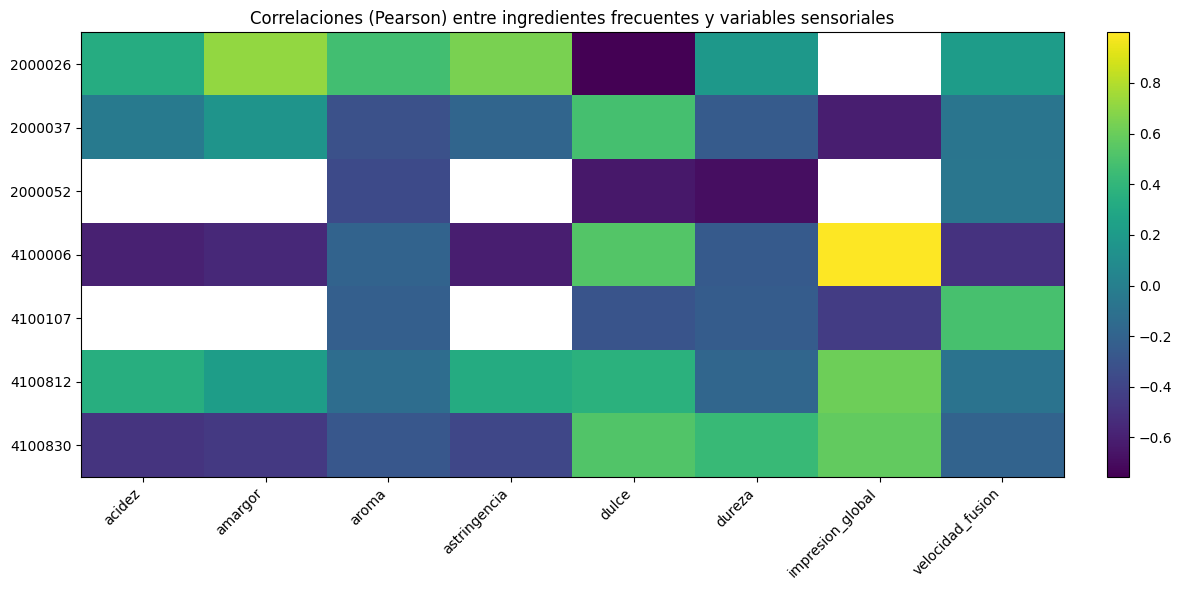

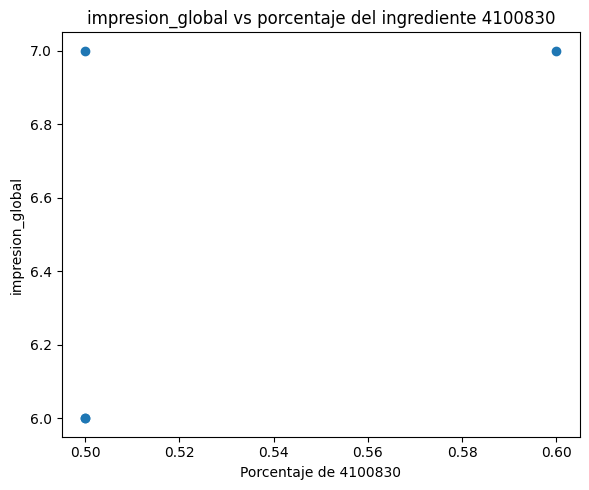

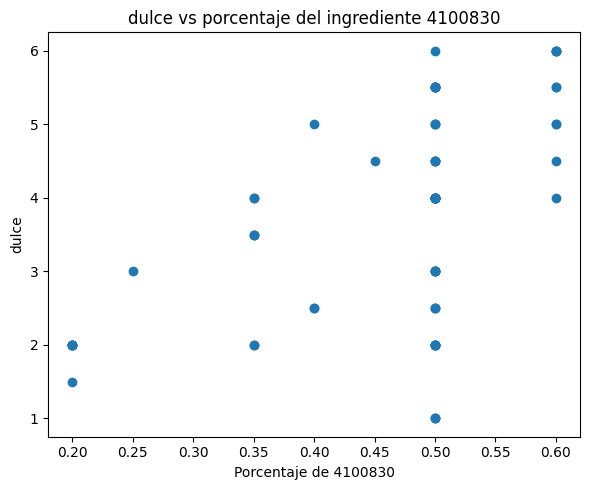

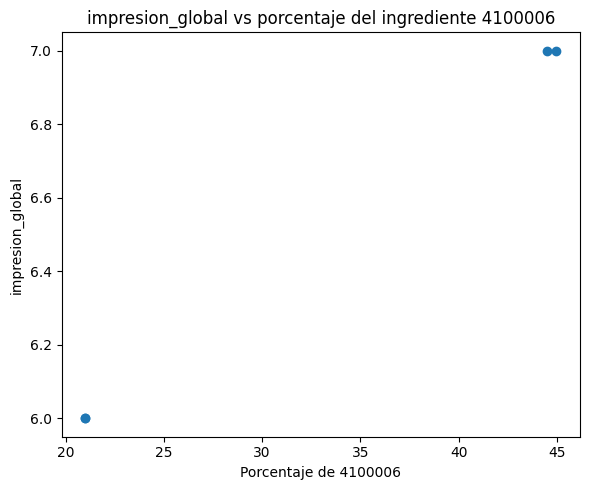

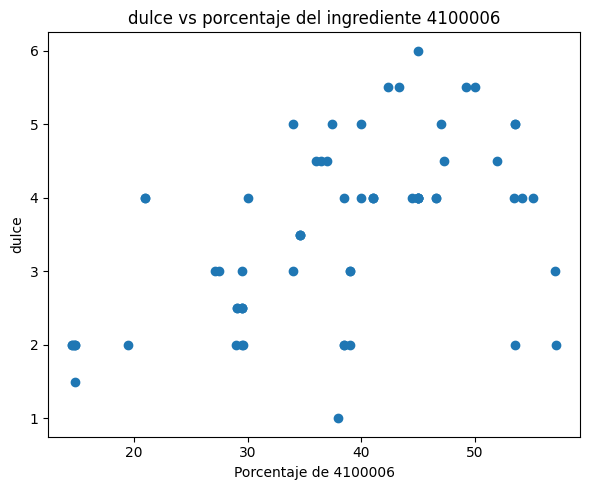

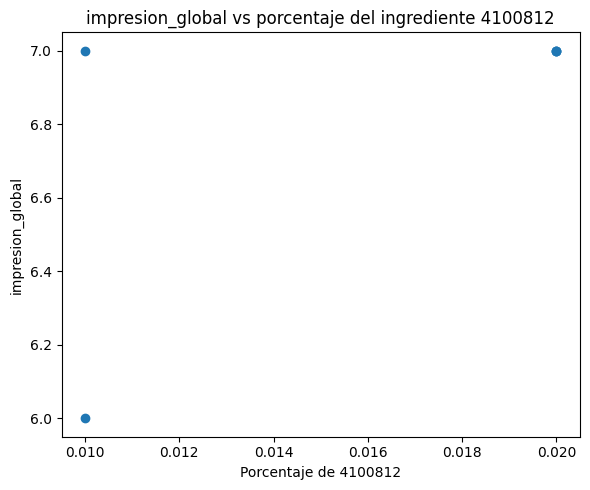

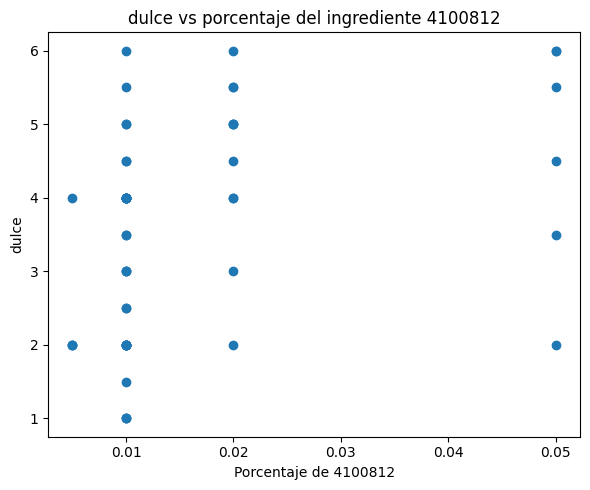

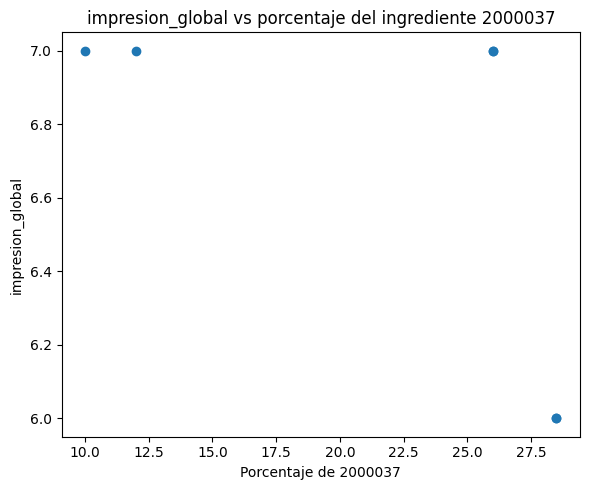

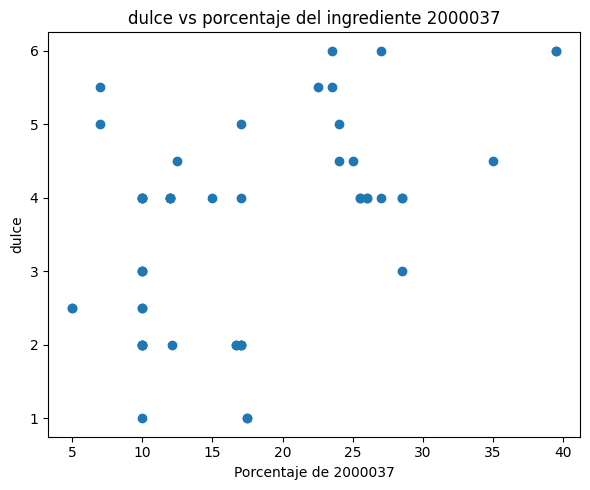

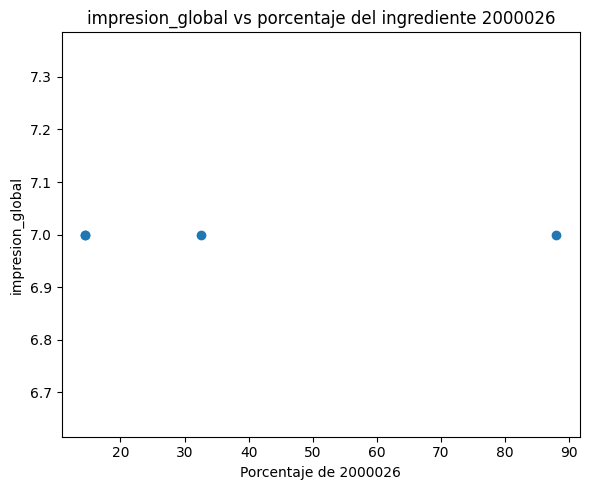

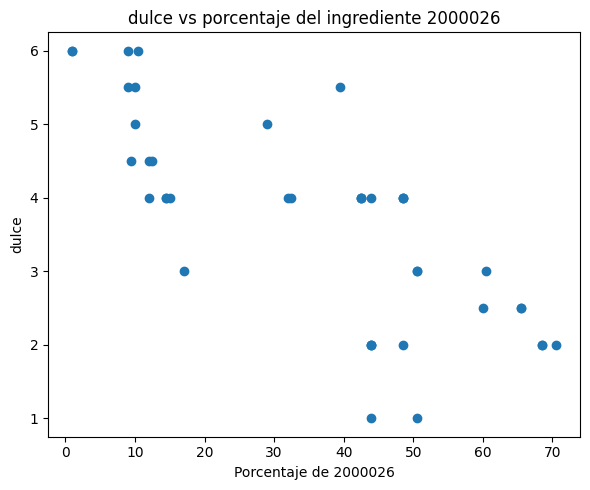

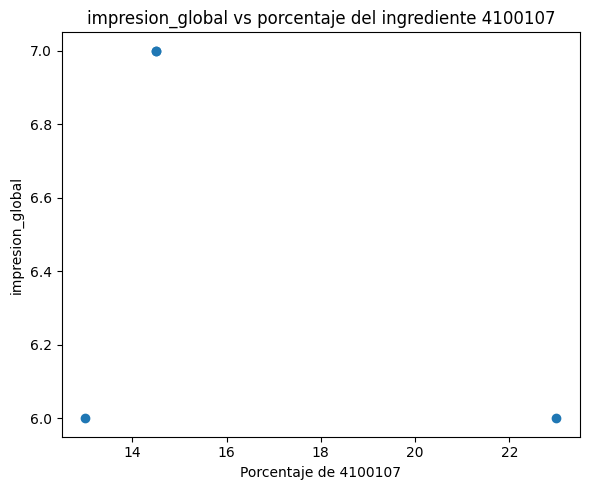

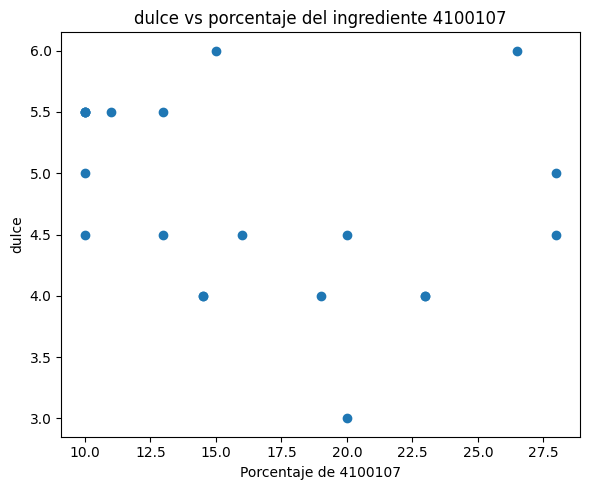

In [47]:
df_recipe = df_recipe_final.apply(pd.to_numeric, errors="coerce")
df_sens = df_sens_final.apply(pd.to_numeric, errors="coerce")

# Umbral de “ingredientes frecuentes”
min_samples = 10
freq_counts = df_recipe.notna().sum(axis=0)
common_ing = freq_counts[freq_counts >= min_samples].index.tolist()

# =========================
# 1) Porcentajes de faltantes
# =========================

# Recetas (muchas columnas): mostramos top-N ordenado
faltantes_rec = df_recipe.isna().mean().sort_values(ascending=False) * 100
topN = 30  # para que la barra sea legible
plt.figure(figsize=(12, 6))
faltantes_rec.head(topN).iloc[::-1].plot(kind="barh")
plt.title("Porcentaje de valores faltantes por ingrediente (Top {}), recetas".format(topN))
plt.xlabel("Porcentaje de faltantes (%)")
plt.ylabel("Ingrediente (código)")
plt.tight_layout()
plt.show()

# Sensorial (8 columnas): todas
faltantes_sens = df_sens.isna().mean().sort_values(ascending=False) * 100
plt.figure(figsize=(8, 5))
faltantes_sens.iloc[::-1].plot(kind="barh")
plt.title("Porcentaje de valores faltantes por variable sensorial")
plt.xlabel("Porcentaje de faltantes (%)")
plt.ylabel("Variable sensorial")
plt.tight_layout()
plt.show()

# =========================
# 2) Distribuciones de valores
# =========================

# 2.1 Sensorial: histograma por variable [1..10]
for col in sens_cols:
    serie = df_sens[col].dropna()
    if serie.empty:
        continue
    plt.figure(figsize=(7, 4))
    plt.hist(serie, bins=np.arange(0.5, 10.6, 1.0), edgecolor="black")
    plt.title(f"Distribución de '{col}' (1–10)")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.xlim(1, 10)
    plt.tight_layout()
    plt.show()

# 2.2 Ingredientes frecuentes: histograma de porcentajes por ingrediente
# Tomamos los 10 más presentes
top_ing = freq_counts.sort_values(ascending=False).head(10).index.tolist()
for col in top_ing:
    serie = df_recipe[col].dropna()
    if serie.empty:
        continue
    plt.figure(figsize=(7, 4))
    plt.hist(serie, bins=20, edgecolor="black")
    plt.title(f"Distribución del ingrediente {col} (porcentaje en receta)")
    plt.xlabel(f"Porcentaje del ingrediente {col}")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# =========================
# 3) Ingredientes más comunes (frecuencia de aparición)
# =========================
plt.figure(figsize=(12, 6))
freq_counts.sort_values(ascending=False).head(20).iloc[::-1].plot(kind="barh")
plt.title("Ingredientes más comunes (Top 20) por número de muestras no nulas")
plt.xlabel("Número de muestras con valor no nulo")
plt.ylabel("Ingrediente (código)")
plt.tight_layout()
plt.show()

# =========================
# 4) Suma por muestra (debería ≈ 100)
# =========================

sum_all = df_recipe.sum(axis=1, skipna=True)
sum_common = df_recipe[common_ing].sum(axis=1, skipna=True) if common_ing else pd.Series(index=df_recipe.index, dtype=float)

# Histograma de la suma usando todas las columnas
plt.figure(figsize=(8, 5))
plt.hist(sum_all.dropna(), bins=20, edgecolor="black")
plt.axvline(100, linestyle="--")
plt.title("Distribución de la suma de porcentajes por muestra (todas las columnas)")
plt.xlabel("Suma de porcentajes")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

# Histograma de la suma usando solo ingredientes frecuentes
if not sum_common.empty:
    plt.figure(figsize=(8, 5))
    plt.hist(sum_common.dropna(), bins=20, edgecolor="black")
    plt.axvline(100, linestyle="--")
    plt.title(f"Distribución de la suma (solo ingredientes frecuentes ≥ {min_samples} muestras)")
    plt.xlabel("Suma de porcentajes")
    plt.ylabel("Número de muestras")
    plt.tight_layout()
    plt.show()

# Comparación de medias (barras)
mean_all = sum_all.mean(skipna=True)
mean_common = sum_common.mean(skipna=True) if not sum_common.empty else np.nan

plt.figure(figsize=(7, 5))
labels = ["Todas las columnas", f"Solo frecuentes (≥{min_samples})"]
vals = [mean_all, mean_common]
plt.bar(labels, vals)
plt.axhline(100, linestyle="--")
plt.title("Suma promedio de ingredientes por muestra")
plt.ylabel("Promedio de la suma")
for i, v in enumerate(vals):
    if pd.notna(v):
        plt.text(i, v, f"{v:.1f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Métricas rápidas impresas en consola (útiles para diagnóstico)
cerca_100 = ((sum_all >= 98) & (sum_all <= 102)).mean() * 100
print(f"• Media suma (todas): {mean_all:.2f}")
print(f"• Media suma (frecuentes ≥{min_samples}): {mean_common:.2f}" if not np.isnan(mean_common) else
      "• No hay ingredientes con frecuencia suficiente para la suma 'frecuentes'")
print(f"• % de muestras con suma entre 98 y 102 (todas): {cerca_100:.1f}%")

# =========================
# 5) Número de ingredientes no nulos por muestra
# =========================
non_null_count = df_recipe.notna().sum(axis=1)
plt.figure(figsize=(8, 5))
plt.hist(non_null_count, bins=20, edgecolor="black")
plt.title("Número de ingredientes presentes (no nulos) por muestra")
plt.xlabel("Cantidad de ingredientes presentes")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

# =========================
# 6) Correlación ingredientes (frecuentes) vs sensorial
# =========================
# Construimos una matriz (ingredientes frecuentes) x (sensorial) con correlaciones de Pearson
max_ing_for_corr = 15  # para que sea legible
ing_for_corr = common_ing[:max_ing_for_corr]

if ing_for_corr and not df_sens.empty:
    # Unimos por índice y calculamos correlaciones
    # Tomamos pares válidos por columnas para evitar sesgos de NaN
    corr_mat = pd.DataFrame(index=ing_for_corr, columns=sens_cols, dtype=float)
    for ing in ing_for_corr:
        for sens in sens_cols:
            x = df_recipe[ing]
            y = df_sens[sens]
            valid = x.notna() & y.notna()
            if valid.sum() >= 3:
                corr_mat.loc[ing, sens] = np.corrcoef(x[valid], y[valid])[0, 1]
            else:
                corr_mat.loc[ing, sens] = np.nan

    # Heatmap simple con matplotlib
    fig = plt.figure(figsize=(12, 6))
    im = plt.imshow(corr_mat.values.astype(float), aspect='auto')
    plt.xticks(ticks=np.arange(len(sens_cols)), labels=sens_cols, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(ing_for_corr)), labels=ing_for_corr)
    plt.title("Correlaciones (Pearson) entre ingredientes frecuentes y variables sensoriales")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# =========================
# 7) Dispersión de algunos ingredientes vs variables sensoriales
# =========================
# Elegimos 6 ingredientes más presentes y graficamos contra 'impresion_global' y 'dulce' si existen
scatter_targets = [c for c in ["impresion_global", "dulce"] if c in df_sens.columns]
for ing in freq_counts.sort_values(ascending=False).head(6).index:
    for sens in scatter_targets:
        x = df_recipe[ing]
        y = df_sens[sens]
        valid = x.notna() & y.notna()
        if valid.sum() < 3:
            continue
        plt.figure(figsize=(6, 5))
        plt.scatter(x[valid], y[valid])
        plt.title(f"{sens} vs porcentaje del ingrediente {ing}")
        plt.xlabel(f"Porcentaje de {ing}")
        plt.ylabel(sens)
        plt.tight_layout()
        plt.show()